## 4.2. Riemann Solver: Rusanov Scheme

Equation 59:

$$f_{1+1/2} = \frac{1}{2}\left( f_{i+1/2}^L + f_{1+1/2}^R \right) - \frac{c_{1+1/2}}{2}\left( u_{1+1/2}^R - u_{i+1/2}^L \right)$$

Equation 60:

$$c_{i+1/2} = max(|u_i|, |u_{i+1}|)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from weno5_scheme import weno5_reconstruction
from rk3 import rk3

ghost_cells_n = 3

x_l, x_r, t = 0, 1, 0.25
nx = 200
dt = 0.0001
dx = (x_r - x_l) / nx
nt = int(t / dt)

x = np.linspace(dx / 2 - ghost_cells_n * dx, x_r - dx / 2 + ghost_cells_n * dx, nx +2 * ghost_cells_n)
u = np.zeros((nt + 1, nx  + 2 * ghost_cells_n))
u[0, :] = np.sin(2 * np.pi * x)

In [2]:
f, rhs_buffer = np.zeros(nx + 1), np.zeros(nx)
flux = lambda x: 0.5 * x ** 2

# for periodic boundary
def update_ghost_cells(buffer):
    buffer[0], buffer[1], buffer[2] = buffer[nx], buffer[nx + 1], buffer[nx + 2]
    buffer[-1], buffer[-2], buffer[-3] = buffer[2 * ghost_cells_n], buffer[2 * ghost_cells_n - 1], buffer[2 * ghost_cells_n - 2]
    
def right_hand_side(u0):

    for i in range(nx + 1):
        value = (u0[i], u0[i + 1], u0[i + 2], u0[i + 3], u0[i + 4])
        uL = weno5_reconstruction(value)
        
        value = (u0[i + 5], u0[i + 4], u0[i + 3], u0[i + 2], u0[i + 1])
        uR = weno5_reconstruction(value)
        
        c = max(np.abs([u0[i + ghost_cells_n - 1], u0[i + ghost_cells_n]]))

        f[i] = 0.5 * (flux(uR) + flux(uL)) - 0.5 * c * (uR - uL)
        
    for i in range(nx):
        rhs_buffer[i] = - (f[i+1] - f[i]) / dx

    return rhs_buffer

In [3]:
intermediate = np.zeros_like(x)
to_update_slice = slice(ghost_cells_n, nx+ghost_cells_n)

for i in range(1, nt+1):
    
    buffer = right_hand_side(u[i-1])
    intermediate[to_update_slice] = rk3(1, u[i-1, to_update_slice], buffer, dt, None)
    update_ghost_cells(intermediate)
    
    buffer = right_hand_side(intermediate)
    intermediate[to_update_slice] = rk3(2, u[i-1, to_update_slice], buffer, dt, intermediate[to_update_slice])
    update_ghost_cells(intermediate)
    
    buffer = right_hand_side(intermediate)
    intermediate[to_update_slice] = rk3(3, u[i-1, to_update_slice], buffer, dt, intermediate[to_update_slice])
    update_ghost_cells(intermediate)
    
    u[i] = intermediate
    

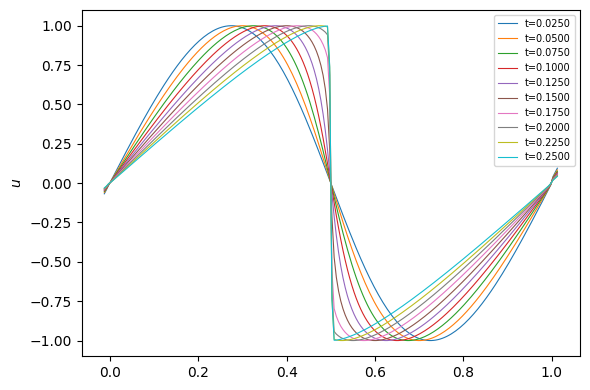

In [4]:
ts = np.linspace(0.025, 0.25, 10)
plt.figure(figsize=(6, 4), dpi=100)
for i, t_stamp in enumerate(ts):
    index = int(t_stamp / dt)
    plt.plot(x, u[index], linewidth=0.8, label="t="+format(t_stamp, ".4f"))
plt.legend(fontsize=7)
plt.ylabel("$x$")
plt.ylabel("$u$")
plt.tight_layout()